# <font color='red'>Baseline Energy Resolution Tutorial</font>

**In this notebook, we calculate the energy resolution of a TES of a dark matter search detector.**

To measure the resolution, the following data and calculations are needed:
 * <font color='blue'>**dIdV traces** </font>(stored in didv_traces.npy). Data taken with test signal (square wave), connected to TES line, and normalized to amps. A 3-pole model  will be used to fit the dIdV data. The configuration (electronics, signal gnerator, TES bias, etc) used to take dIdV is stored in data_resolution.hdf5. <br> <br>
 
 * <font color='blue'>**Prior results from a IV sweep:**</font>  The I0 "offset" from IV sweep (see IV demo) will be used to measure the **true I0 and R0** from the dIdV data baseline measurement. This will allow us to more accurately calculate the "**small signal" parameters** (Irwin's loop gain,  beta, thermal time constant, and inductance) and **their  uncertainties** from the dIdV fit result. These parameters will then be used to to calculate the  **power-to-current transfer function dPdI** below.<br> <br>
 
 * <font color='blue'>**Randoms traces**:</font>  The **noise PSD** (2-sided) in Amps^2/Hz will be calculated using 20ms randoms traces stored in randoms.npy file (2D numpy array). The traces are already converted to Amps. A pileup rejection will be done.  <br> <br>
 
 * <font color='blue'>**dPdI**</font> in Volts, which will be calculated from dIdV and small signal parameters, over the frequencies used for the PSD.<br> <br>
 
 * <font color='blue'>**Pulse template**:</font> We will use two different templates: A functional form that was optimized using triggered data and a template based on dPdI parameters assuming a **dirac delta power deposit**. 
 
 <br> 
 
With the above data, the <font color='green'>**baseline energy resolution**</font> in units of eV  will be calculated  using **2 methods**:     
  1. **Direct resolution calculation**
  2. Firt computing the **Optimum Filter amplitude**, then normalizing to eV (OF 1x1 class, see fitting demos), and finally performing a gaussian fit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
import scipy as sp
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')


## dIdV 

Let's first calculate **dIdV**  by fitting the data taken with a signal generator (square wave) connected to TES line (aka "*dIdV traces*")

We will use in particular a  **3 poles model** to fit the data:

$\frac{dV}{dI}(f) = A(1 + 2 i \pi f \tau_2) + \frac{B}{1 + 2 i \pi f \tau_1 - C/(1 + 2 i \pi f \tau_3)}$


#### Load didv data

The file data_resolution.hdf5 contains the dIdV traces, as well as information about signal generator, digitizer, and SQUID readout amplifier

In [3]:
# Let's dIdV traces (already normalized to amps)
didv_traces = np.load('didv_traces.npy')
didv_config = pd.read_hdf('data_resolution.hdf5', 'data_config')

# traces in amps, 2D array (150, 32000)
sample_rate = didv_config['fs']

# TES bias  
tes_bias = didv_config['tes_bias']

# readout amplifier configuration used for data taking
didv_output_offset = didv_config['output_variable_offset']
didv_output_gain = didv_config['output_variable_gain']

# normalization to convert output voltage to current in TES
didv_close_loop_norm = didv_config['close_loop_norm']

# signal generator information
sg_freq = didv_config['sgfreq'] # frequency in  Hz
sg_amps = didv_config['sgamp'] # amplitude in Amps

# other needed parameters
rshunt = didv_config['rshunt'] # a 5 mohms shunt resistance is used

#### Instantiate QETpy DIDV, process traces and do fit

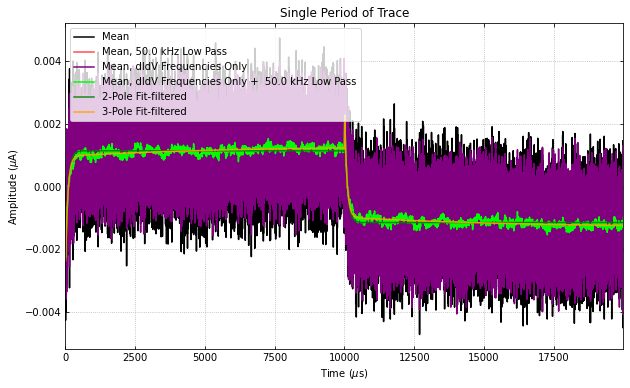

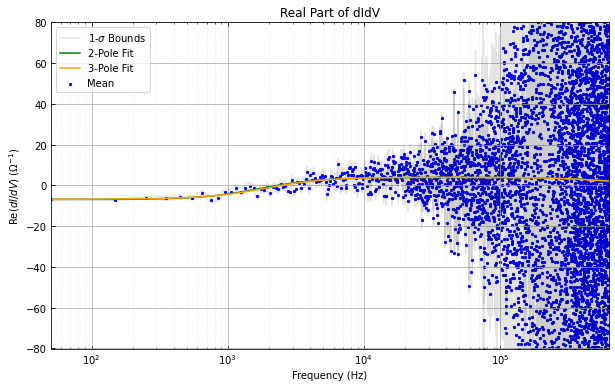

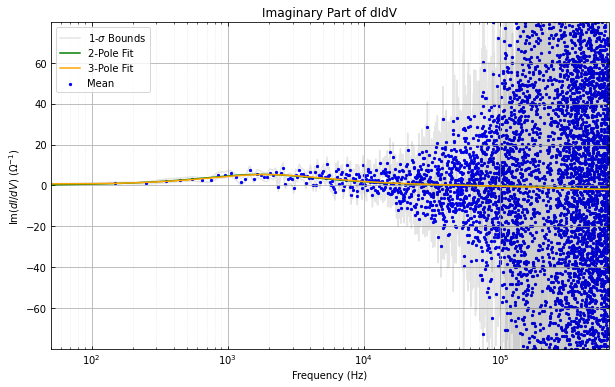

In [4]:
# Instantiate dIdV
didvfit = qp.DIDV(didv_traces, 
                  sample_rate,
                  sg_freq,
                  sg_amps,
                  rshunt,)

# process
didvfit.processtraces()

# fit 
didvfit.dofit(2) # Two poles fit
didvfit.dofit(3) # Tree poles fit

# display
didvfit.plot_single_period_of_trace(didv_freq_filt=True, lp_cutoff=50e3)
didvfit.plot_re_im_didv()

## Small Signal Parameters and their Uncertainties

In order to calculate dPdI from dVdI, we need to first calculate the small signal parameters, which describe the properties of the TES.  
 
The main 5 parameters that are calculated for a **3 pole model** are:
- $\beta$, "beta", i.e. the **current sensitivity**
- $\mathcal{L}$, "l", i.e. the **loopgain**
- $L_{eff}$, "L", i.e. the effective system **inductance** at the bias point
- $\tau_0$, "tau0", i.e. the **thermal time constant** (C/G)
- "gratio", i.e. the ratio between the second and third pole thermal conductances G

These parameters are useful in for instance understanding the properties of the W TES film ($\beta$), how strong the electrothermal feedback is $\mathcal{L}$, etc. 

In order to properly calculate the above small signal parameters from the fit parameters, we need a prior knowledge of **I0**, **R0**, and **Rload** (as well as their uncertainties) which are calculated from **IV sweep analysis**. 

**However**, if the TES state has slightly changed since IV sweep data (for example TES further cooling down or noise environment has changed) then I0/R0 might not be accurate. Thus it is best ot calculate the **true I0** can  using the measured baseline offset knowing the **I0 offset** (="offset" used in the IV analysis to correct the measured current in the TES to get I0).   **In this demo, we will calculate the true i0!**


**IMPORTANT NOTE**:  **The readout configuration such as variable gain and offset may have changed between IV sweep and dIdV only data and needs to be properly taken into account to calculate true I0,R0!**  Thus we also stored the readout electronics variable offset and gain from IV sweep in data_resolution.hdf5 file. 

**WARNING: If the readout electronics gain and offset are not linear, the result will be inaccurate!**

**Load IV sweep result** (as pandas series) and convert to dictionary. 

In [5]:
# We will recalculate I0/R0 so we need I0/Ibias offset
ivsweep_results = pd.read_hdf('data_resolution.hdf5', 'ivsweep')
ivsweep_results = ivsweep_results.to_dict()

# print data 
print('Results from prior IV sweep analysis:\n')
pprint(ivsweep_results)

Results from prior IV sweep analysis:

{'close_loop_norm': 625000.0,
 'group_name_sweep': 'iv_didv_I2_D20230923_T131239',
 'i0': 1.2510621880090041e-07,
 'i0_err': 8.342312444985714e-12,
 'i0_off': 3.89669341000469e-09,
 'i0_off_err': 5.507092047349402e-12,
 'i0_variable_offset': -9.865689873695374e-06,
 'ibias_off': -3.381406772500224e-08,
 'ibias_off_err': 1.0347074588426951e-11,
 'lgc_invert_offset': True,
 'output_variable_gain': 50.0,
 'output_variable_offset': -0.12332112342119217,
 'p0': 2.7194163442462373e-15,
 'p0_err': 5.532206867147335e-17,
 'r0': 0.1737472370023056,
 'r0_err': 0.003534606260879604,
 'rn': 0.8713947570750865,
 'rn_err': 0.017587140432555274,
 'rp': 0.0029572918826476936,
 'rp_err': 5.9145837652953874e-05,
 'rshunt': 0.004999999888241291,
 'rshunt_err': 9.999999776482583e-05}


**Let's now calculate  true I0/R0 and "small signal" parameters**

If you prefer to use i0, r0 from IV sweep without recalculation of true current, 
set calc_true_current=False. 
In this case, parameters "i0", "i0_err", "r0", and "r0_err"
need to be stored in the "ivsweep_results" dictionary!

In [6]:
didvfit.calc_smallsignal_params(ivsweep_results,
                                calc_true_current=True,
                                tes_bias=tes_bias,
                                close_loop_norm=didv_close_loop_norm,
                                output_variable_gain=didv_output_gain,
                                output_variable_offset=didv_output_offset,
                                inf_loop_gain_approx='auto')

INFO: Calculating true current!
INFO: Loop gain is negative for 2-poles fit. Will use infinite loop gain approximation!
INFO: Calculating bias parameters with infinite loop gain approximation for 2-poles fit!
INFO: Loop gain is negative for 3-poles fit. Will use infinite loop gain approximation!
INFO: Calculating bias parameters with infinite loop gain approximation for 3-poles fit!


Let's check fit result, calculation of true current and mall signal parameters

In [7]:
fit_result_3pole = didvfit.fitresult(3)

# let's print true I0/R0
print('i0 from IV sweep: {:.3g} +/- {:.3g} muAmps'.format(ivsweep_results['i0']*1e6, 
                                                    ivsweep_results['i0_err']*1e6))


print('i0 true: {:.3g} +/- {:.3g} muAmps'.format(fit_result_3pole['biasparams']['i0']*1e6, 
                                          fit_result_3pole['biasparams']['i0_err']*1e6))

print( ' ')
print('r0 from IV sweep: {:.3g} +/- {:.3g} muOhms'.format(ivsweep_results['r0']*1e3, 
                                                    ivsweep_results['r0_err']*1e3))
print('r0 true: {:.3g} +/- {:.3g} mOhms'.format(fit_result_3pole['biasparams']['r0']*1e3, 
                                                fit_result_3pole['biasparams']['r0_err']*1e3))
print( ' ')
print('p0 from IV sweep: {:.3g} +/- {:.3g} fWatts'.format(ivsweep_results['p0']*1e15, 
                                                    ivsweep_results['p0_err']*1e15))


print('p0 true: {:.3g} +/- {:.3g} fWatts'.format(fit_result_3pole['biasparams']['p0']*1e15, 
                                           fit_result_3pole['biasparams']['p0_err']*1e15))


i0 from IV sweep: 0.125 +/- 8.34e-06 muAmps
i0 true: 0.159 +/- 0.000532 muAmps
 
r0 from IV sweep: 174 +/- 3.53 muOhms
r0 true: 135 +/- 0.481 mOhms
 
p0 from IV sweep: 2.72 +/- 0.0553 fWatts
p0 true: 3.4 +/- 0.0114 fWatts


#### Fall Times

Now, let's take a look at the falltimes.

IT'S VERY IMPORTANT TO NOTE THAT THESE FIT FALLTIMES ARE NOT THE SAME AS THE DIDV POLES!

These parameters are fit in this way because it corresponds to a physical model, which separates the contributions of the electrical inductance and the thermal feedback in modeling the response of the system. For very low inductance and slow thermal systems, the fit parameters approach the true system poles, but aren't identical.

The true poles are also included in the result object.

In [8]:
print('Fit time constants, NOT dIdV Poles: ')
print('Tau1: {:.3g} s'.format(np.abs(fit_result_3pole['params']['tau1'])))
print('Tau2: {:.3g} s'.format(fit_result_3pole['params']['tau2']))
print('Tau3: {:.4g} s'.format(fit_result_3pole['params']['tau3']))
print(' ')

print('True dIdV Poles: ')
print('Tau_plus: {:.3g} s'.format(fit_result_3pole['falltimes'][0]))
print('Tau_minus: {:.3g} s'.format(fit_result_3pole['falltimes'][1]))
print('Tau_third: {:.4g} s'.format(fit_result_3pole['falltimes'][2]))

Fit time constants, NOT dIdV Poles: 
Tau1: 4.93e-05 s
Tau2: 2.38e-07 s
Tau3: 0.005622 s
 
True dIdV Poles: 
Tau_plus: 2.4e-07 s
Tau_minus: 8.27e-05 s
Tau_third: 0.006253 s


We can also take a look at the correlation matrix of the small signal parameters to see how the uncertainties in these variables are related.

For 3-poles fit, a smaller covariance matrix is stored with "ssp_light" key in the result dictionary 

{'L': 6.050667596619169e-08,
 'beta': 0.8158819264705817,
 'gratio': 1.0000000000000007,
 'l': 18.034632857661315,
 'tau0': 0.0008390950454468598}


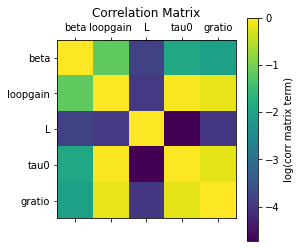

In [9]:
cov_matrix = np.abs(fit_result_3pole['ssp_light']['cov'])
vals_vector = fit_result_3pole['ssp_light']['vals']
pprint(vals_vector)
cor_matrix = np.zeros([5,5])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j]))
        j += 1
    i += 1

labels = ['beta', 'loopgain', 'L', 'tau0', 'gratio']
ticks = np.arange(0, 5, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

As you can see, there's a lot of correlation between the **loopgain and the tau0**, 
far away from transition where the loopgain is large, they're highly correlated.

### Noise PSD

The noise PSD has been pre-calculate and is stored in data_resolution.hdf5. 

This is a **2-sides noise PSD in Amps^2/Hz** (see QETpy noise demos for PSD calculation)

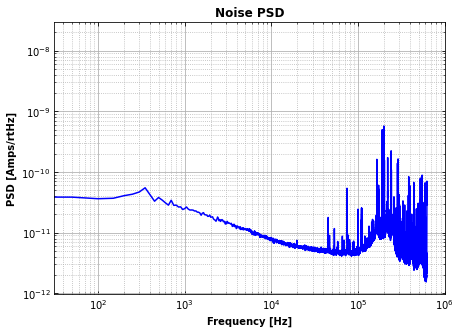

In [10]:
# Load randoms  traces (20ms traces, already normalized to be a Amps)

# load from file
randoms  = np.load('randoms_traces.npy')

# apply pile-up rejections
cut = qp.autocuts_noise(randoms)
randoms_cut = randoms[cut]

# calc  2-sided PSD [Amps^2/Hz]
psd_freqs, psd = qp.calc_psd(randoms_cut, fs=sample_rate, folded_over=False)

# display
# We first fold psd, then convert to Amps/rtHz
freqs_fold, psd_fold = qp.foldpsd(psd, fs=sample_rate)
psd_fold = psd_fold**0.5

fig, ax = plt.subplots(figsize=(7, 5))
plt.loglog(freqs_fold, psd_fold, color='b')
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.grid(which='minor', linestyle='dotted')
plt.grid(which='major')
plt.title('Noise PSD',fontweight='bold')
plt.xlabel('Frequency [Hz]',fontweight='bold')
plt.ylabel('PSD [Amps/rtHz]',fontweight='bold')
plt.show()

## dPdI

Now that we calculated dIdV and small signal parameters, we can calculate dPdI over the frequencies used for PSD

**dPdI is in unit of Volts**

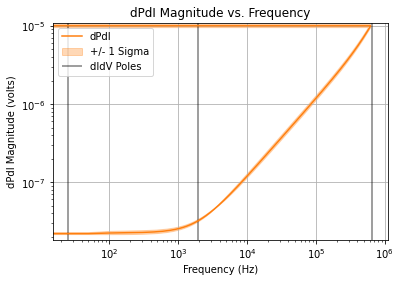

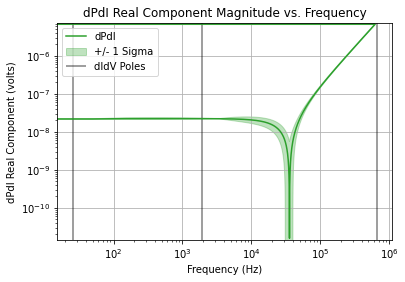

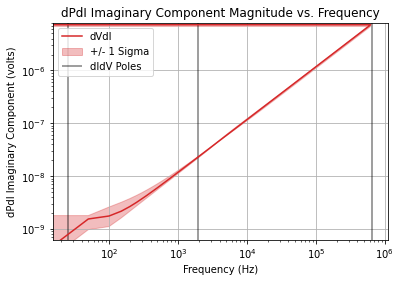

In [11]:
dpdi, dpdi_err = qp.get_dPdI_with_uncertainties(psd_freqs, fit_result_3pole,
                                                lgcplot=True)

## TES power noise

With the known power-to-current transfer function dPdI, we can calculate 
Noise-Equivalent Power (NEP):

$S_{P}(\omega) = \frac{S_{Itot}(\omega)}{|\frac{\partial I}{\partial P}(\omega)|^2}$

We switch to using the square root of the power noise, the noise-equivalent power:

$NEP(\omega) = \sqrt{S_{Ptot}(\omega)}$

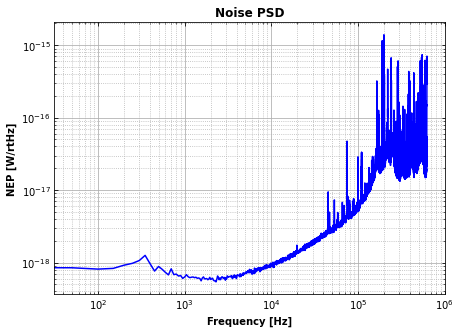

In [12]:
# power noise W^2/Hz  (2-sided)
#   - psd is the double-sided noise in amps^2/Hz
#   - dpdi is in Volts

noise_power = psd*np.abs(dpdi)**2

# display 

# let's fold the PSD 
freqs_fold, noise_power_folded =  qp.foldpsd(noise_power, sample_rate)

# Let's display in W/rtHz
noise_power_folded= np.sqrt(noise_power_folded)



fig, ax = plt.subplots(figsize=(7, 5))
plt.loglog(freqs_fold, noise_power_folded, color='b')
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.grid(which='minor', linestyle='dotted')
plt.grid(which='major')
plt.title('Noise PSD',fontweight='bold')
plt.xlabel('Frequency [Hz]',fontweight='bold')
plt.ylabel('NEP [W/rtHz]',fontweight='bold')
plt.show()


# Note, QETpy has a function to convert in power (currently for folded PSD in A/rtHz)
noise_power_folded, noise_power_folder_err = (
    qp.get_power_noise_with_uncertainties(freqs_fold, psd_fold,
                                          fit_result_3pole,
                                          lgcplots=False, 
                                          lgcdpdireturn=False)
)


## Templates

**Let's create two different templates:**

  * template as the  sum of a fast and slow single fall time functional form. The coeffecients have been optimized to fit pulses (in power)  in a separate analysis. 
  * dIdV template using calculated dPdI parameters, assuming a dirac delta power deposit

In [13]:
#  The template will be 20ms traces, with 10ms pre-trigger time
pretrigger = 10e-3 

# time array
dt = 1/sample_rate
time_array = np.arange(psd.shape[-1])*dt

# Current Template  (dirac delta power input)
template_didv = qp.get_didv_template(time_array, pretrigger, fit_result_3pole)
template_didv = template_didv/np.max(template_didv)

# Template based on actual pulse
# (power template)

# slow and fast components
pulse_fast = qp.utils.make_template_twopole(
    time_array, A = 1.0,
    tau_r=15e-6, tau_f=150e-6, 
    t0=10e-3, fs=sample_rate)

pulse_slow = qp.utils.make_template_twopole(
    time_array, A = 1.0,
    tau_r=1e-6, tau_f=1000e-6, t0=10e-3, fs=1.25e6)

# take teh sum and normalize to amplitude
template_pulse = pulse_fast*1.2 + 0.12*pulse_slow
template_pulse = template_pulse/np.max(template_pulse)

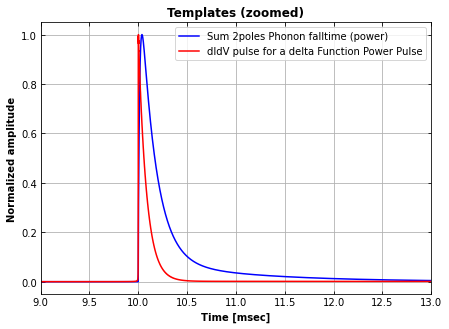

In [14]:
# display 
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(time_array*1e3, template_pulse, color='b',
         label = "Sum 2poles Phonon falltime (power)")
plt.plot(time_array*1e3, template_didv, color='r',
         label = "dIdV pulse for a delta Function Power Pulse")

plt.tick_params(which='both', direction='in', right=True, top=True)
plt.grid(which='minor', linestyle='dotted')
plt.grid(which='major')
plt.title('Templates (zoomed)',fontweight='bold')
plt.xlabel('Time [msec]',fontweight='bold')
plt.ylabel('Normalized amplitude',fontweight='bold')
plt.xlim(9,13)
plt.legend(loc='best')
plt.show()

## Baseline Energy resolution 

The baseline resolution can be calculated using the following equation (using two-sided quantities):

$\sigma_E = [\int_{-\infty}^{\infty}\frac{d\omega}{2\pi}\frac{|p(\omega)^2|}{S_P (\omega)}]^\frac{1}{2}$

where
 * $p(\omega)$ is template in Fourier space
 * $S_{P}(\omega)$ is the TES power noise  derived earlier



For the calculation below we will assume **100% collection efficiency**!

In [15]:
# calculate resolution for pulse template
# (already power template)
resolution_template_pulse = qp.utils.energy_resolution(psd, template_pulse, dpdi, sample_rate,collection_eff=1)


# calculate resolution for didv template
# -> need to converto power
template_didv_power = qp.convert_template_to_power(template_didv, dpdi=dpdi)
resolution_template_didv = qp.utils.energy_resolution(psd, template_didv, dpdi, sample_rate,collection_eff=1, lgc_current_template=True)

# print
print('Resolution with sum 2 pole template" {:.2f} meV'.format(resolution_template_pulse*1000))
print('Resolution with template from dirac delta power deposit: {:.2f} meV'.format(resolution_template_didv*1000))


Resolution with sum 2 pole template" 76.92 meV
Resolution with template from dirac delta power deposit: 15.90 meV


### Energy Resolution using Optimal Filter

We can also calculate the energy resolution by first calcuting the optimal filter resolution, then convert to eV. 
<br><b>The power template must be converted in to current!</b><br><br>
The resolution can be also calculated using optimimal filter amplitudes (no delay) then using a Gaussian fit of the amplitudes converted to eV.


#### Template sum 2 poles

In [16]:
# convert template in current template
template_pulse_current = qp.convert_template_to_current(template_pulse, dpdi)

# OF 1x1  amplitude resolution
OF1x1_pulse = qp.OF1x1(template=template_pulse_current, psd=psd, sample_rate=sample_rate,
                       pretrigger_msec=10, verbose=False)
ofamp_resolution_pulse = OF1x1_pulse.get_amplitude_resolution()

# normalization OF amplitude to eV 
ofamp_to_ev_pulse = qp.get_energy_normalization(time_array, template_pulse_current, 
                                                didv_result=fit_result_3pole, lgc_ev=True)

# energy resolution
energy_resolution_pulse = ofamp_resolution_pulse * ofamp_to_ev_pulse

print('Resolution from OF with sum 2 pole template: {:.2f} meV'.format(energy_resolution_pulse *1000))

# we can also use a simple dPdI(0) approximationb
ofamp_to_ev_pulse_simple= qp.get_simple_energy_normalization(time_array, template_pulse_current, 
                                                              fit_result_3pole, lgc_ev=True)

energy_resolution_pulse_simple = ofamp_resolution_pulse * ofamp_to_ev_pulse_simple

print('Resolution with dPdI(0) approx. from OF with sum 2 pole template: {:.2f} meV'.format(energy_resolution_pulse_simple *1000))


Resolution from OF with sum 2 pole template: 76.93 meV
Resolution with dPdI(0) approx. from OF with sum 2 pole template: 76.93 meV


#### Template based on direct delta deposit

In [17]:
# OF 1x1  amplitude resolution
OF1x1_didv = qp.OF1x1(template=template_didv, psd=psd, sample_rate=sample_rate,
                       pretrigger_msec=10,verbose=False)
ofamp_resolution_didv = OF1x1_didv.get_amplitude_resolution()

# normalization OF amplitude to eV
ofamp_to_ev_didv= qp.get_energy_normalization(time_array, template_didv, dpdi=dpdi, lgc_ev=True)

# energuy resolution
energy_resolution_didv = ofamp_resolution_didv * ofamp_to_ev_didv
print('Resolution with template from dirac delta power deposit: {:.2f} meV'.format(energy_resolution_didv*1000))

# we can also use a simple dPdI(0) approximationb
ofamp_to_ev_didv_simple = qp.get_simple_energy_normalization(time_array, template_didv, 
                                                              fit_result_3pole, lgc_ev=True)

energy_resolution_didv_simple = ofamp_resolution_didv * ofamp_to_ev_didv_simple

print('Resolution with dPdI(0) approx. from dirac delta power deposit: {:.2f} meV'.format(energy_resolution_didv_simple *1000))


Resolution with template from dirac delta power deposit: 15.90 meV
Resolution with dPdI(0) approx. from dirac delta power deposit: 15.90 meV


### Energy resolution through a Gaussian fit of the Calibrated OF amplitudes

For this calculation, we will use template based on **dirac delta power deposit**

In [18]:
# let's calculate the OF amps (no delay)
ofamps= []

for ievt in range(randoms_cut.shape[0]):
    OF1x1_didv.calc_nodelay(signal=randoms_cut[ievt,:])
    ofamp,oft0,ofchi2,_ = OF1x1_didv.get_result_nodelay()
    ofamps.append(ofamp)
    
  
# calibrate 
energies = np.asarray(ofamps) * ofamp_to_ev_didv

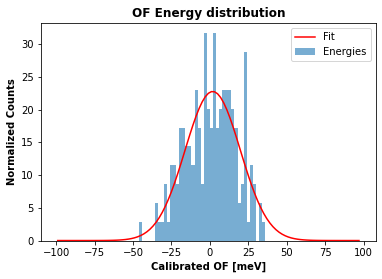

Resolution from gaussian fit (template from dirac delta power deposit): 17.97 meV


In [19]:
# Define the Gaussian function
def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation**2))


# Let's first bin the data
bins = np.arange(-0.1, 0.1, 2e-3)
vals, bin_borders = np.histogram(energies, bins=bins, density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2


# Perform the curve fit
popt, pcov = sp.optimize.curve_fit(gaussian, bin_centers, vals)

# Extracting the parameters
amplitude, mean, std_dev = popt

# Plot the data and the fit
plt.figure()
plt.bar(bin_centers*1000, vals, width=np.diff(1000*bin_borders), align='center', alpha=0.6, label='Energies')
plt.plot(bin_centers*1000, gaussian(bin_centers, *popt), label='Fit', color='red')
plt.legend()
plt.title('OF Energy distribution',fontweight='bold')
plt.xlabel('Calibrated OF [meV]',fontweight='bold')
plt.ylabel('Normalized Counts',fontweight='bold')
plt.show()


# print resolution
res = np.abs(std_dev)
print('Resolution from gaussian fit (template from dirac delta power deposit): {:.2f} meV'.format(res*1000))
